In [9]:
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
import shap
import json
import numpy as np

In [10]:
# Mean and std value to normalize the images from ImageNet dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

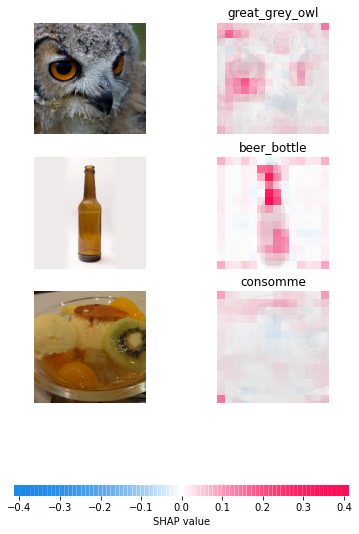

In [12]:
# load the model
model = models.vgg19(pretrained=True).eval()

# X is the dataset to be used as the background distribution
X,_ = shap.datasets.imagenet50()

# Limit the pixel value to 0-1
X /= 255

# Select the input images from X dataset,e.g.,the 39th and the 41th images
to_explain = X[[35, 40, 20]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    # Save the class names in class_names
    class_names = json.load(f)

# call the GradientExplainer function
# model.features[34]: the last convolutional layer in Vgg19 network
e = shap.GradientExplainer((model, model.features[34]), normalize(X))
# Calculate the shap values. Ranked_output=1: top-1 prediction. 
# nsamples: the number of the samples to calculate the exceptions
shap_values,indexes = e.shap_values(normalize(to_explain), ranked_outputs=1, nsamples=50)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values] # roll the axis so that they can be plotted

shap.image_plot(shap_values, to_explain, index_names)